# Data Acquisition

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
df = yf.download("MSFT", start="2010-01-01", end="2024-07-18")
dfDict = df.to_csv("data.csv")
df = pd.read_csv("data.csv", parse_dates=True, index_col='Date')
df.drop('Adj Close', axis=1, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df.ffill(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df["Var"] = df["Close"] - df["Open"]
df["VarP"] = (df["Var"] * 100) / df["Open"]
df["Sum"] = df["Var"].cumsum()
df["SumP"] = (df["Sum"] * 100) / df["Open"].iloc[0]

In [4]:
df.head()

,Open,High,Low,Close,Volume,Var,VarP,Sum,SumP
Date,,,,,,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001,38409100.0,0.330000,1.077727,0.330000,1.077727
2010-01-05,30.850000,31.100000,30.639999,30.959999,49749600.0,0.109999,0.356560,0.439999,1.436965
2010-01-06,30.879999,31.080000,30.520000,30.770000,58182400.0,-0.109999,-0.356213,0.330000,1.077727
2010-01-07,30.629999,30.700001,30.190001,30.450001,50559700.0,-0.179998,-0.587654,0.150002,0.489881
2010-01-08,30.280001,30.879999,30.240000,30.660000,51197400.0,0.379999,1.254951,0.530001,1.730897


# Sequence and Series Analysis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

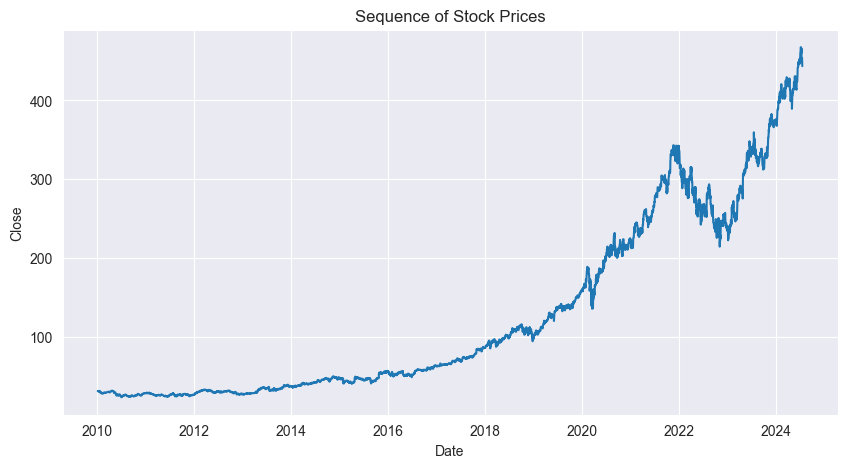

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Close", data=df)
plt.title('Sequence of Stock Prices')
plt.show()

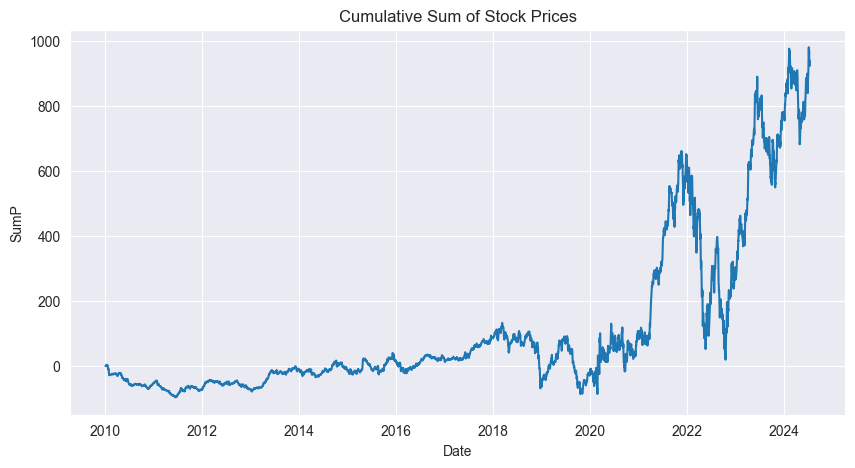

In [7]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="SumP", data=df)
plt.title("Cumulative Sum of Stock Prices")
plt.show()

# Moving Averages Calculation

In [8]:
df['SMA5'] = df['Close'].rolling(5).mean()
df['SMA10'] = df['Close'].rolling(10).mean()
df['SMA20'] = df['Close'].rolling(20).mean()

In [9]:
# Fill or drop missing values if any
df.dropna(inplace=True)

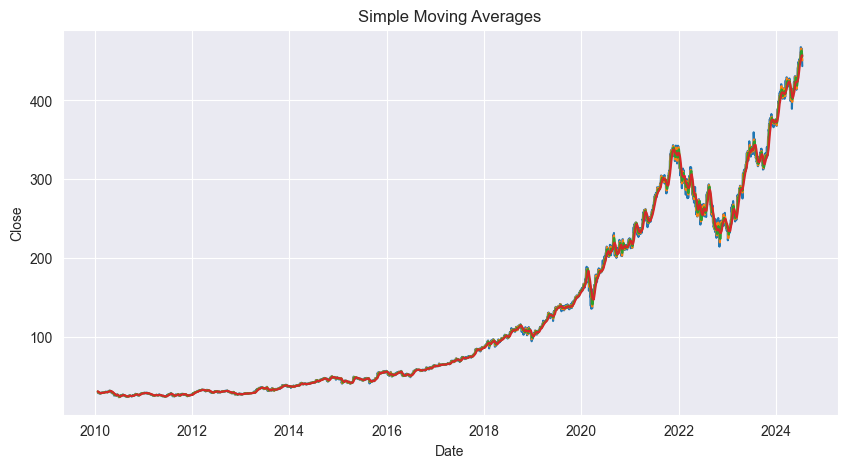

In [10]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Close", data=df)
sns.lineplot(x="Date", y="SMA5", data=df)
sns.lineplot(x="Date", y="SMA10", data=df)
sns.lineplot(x="Date", y="SMA20", data=df)
plt.title("Simple Moving Averages")
plt.show()

# Time Series Decomposition

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
# Assuming the time series is in a DataFrame column 'value'
ts = df['Close']

# Decompose the time series
decomposition = seasonal_decompose(ts, model='additive', period=116)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

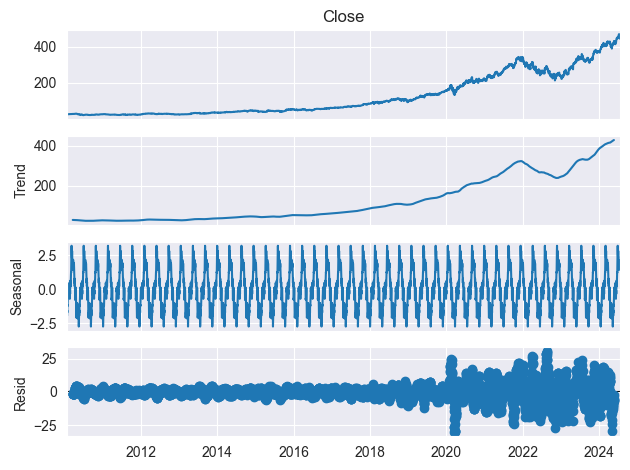

In [13]:
decomposition.plot()
plt.show()

# Predictive Modeling

##### Creating the training and test datasets (80% training, 20% testing).

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Sequential

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


##### Creating the function to create sequence for LSTM.

In [16]:
def create_sequences(data, sequence_length=90):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)


##### Reshaping data for LSTM input

In [17]:
sequence_length = 90
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

##### Building the LSTM model and trianing the model.


In [1174]:
model = Sequential()

# Define the input layer with the input shape
model.add(Input(shape=(x_train.shape[1], 1)))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0096
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 3.4926e-04
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 3.5834e-04
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.1605e-04
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 3.2558e-04
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.5326e-04
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.9756e-04
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.4367e-04
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.3424e-04
Epoch 10/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.4127e-04
Epoch 11/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.5802e-04
Epoch 12/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 2.2232e-04
Epoch 13/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 2.5153e-04
Epoch 14/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 2.

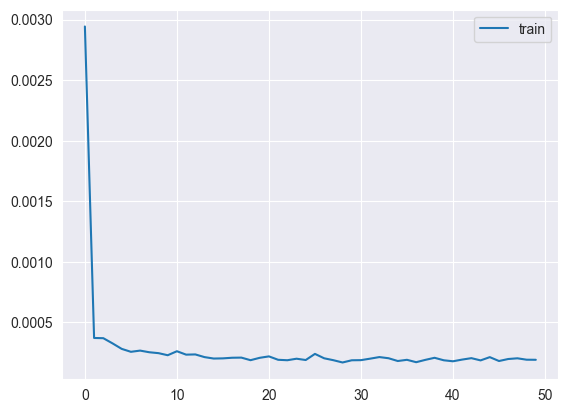

In [1183]:
plt.plot(history.history['loss'][:], label='train')
plt.legend()
plt.show()

##### Making predictions.

In [1184]:
predicted_test = model.predict(x_test)
predicted_test = scaler.inverse_transform(predicted_test)

predicted_train = model.predict(x_train)
predicted_train = scaler.inverse_transform(predicted_train)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [1185]:
##### Plotting the results.

In [1186]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

In [1187]:
# calculate performance metrics
trainScore = mean_squared_error(df['Close'].values[:train_size-sequence_length], predicted_train[:,0])
print(f'Train Score: {trainScore} MSE')
trainScore = root_mean_squared_error(df['Close'].values[:train_size-sequence_length], predicted_train[:,0])
print(f'Train Score: {trainScore} RMAE')
trainScore = mean_absolute_error(df['Close'].values[:train_size-sequence_length], predicted_train[:,0])
print(f'Train Score: {trainScore} MAE \n')



testScore = mean_squared_error(df['Close'].values[train_size+sequence_length:], predicted_test[:,0])
print(f'Test Score: {testScore} MSE')
testScore = root_mean_squared_error(df['Close'].values[train_size+sequence_length:], predicted_test[:,0])
print(f'Test Score: {testScore} RMAE')
testScore = mean_absolute_error(df['Close'].values[train_size+sequence_length:], predicted_test[:,0])
print(f'Test Score: {testScore} MAE')

Train Score: 101.32691566303714 MSE
Train Score: 10.066127143198477 RMAE
Train Score: 6.33542982706524 MAE 

Test Score: 91.87751574828734 MSE
Test Score: 9.5852759870693 RMAE
Test Score: 7.745469511047871 MAE


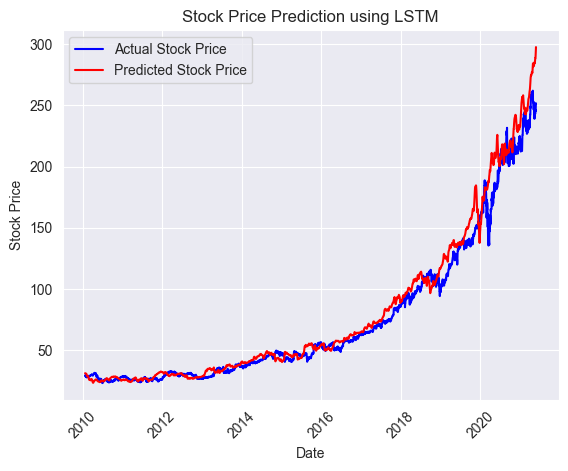

In [1188]:
# Train set
plt.plot(df.index[:train_size-sequence_length], df['Close'].values[:train_size-sequence_length], color='blue', label='Actual Stock Price')
plt.plot(df.index[:train_size-sequence_length], predicted_train, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

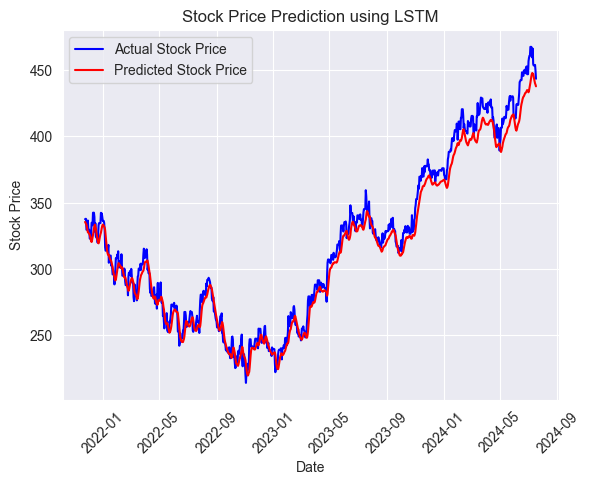

In [1189]:
# Test set
plt.plot(df.index[train_size+sequence_length:], df['Close'].values[train_size+sequence_length:], color='blue', label='Actual Stock Price')
plt.plot(df.index[train_size+sequence_length:], predicted_test, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

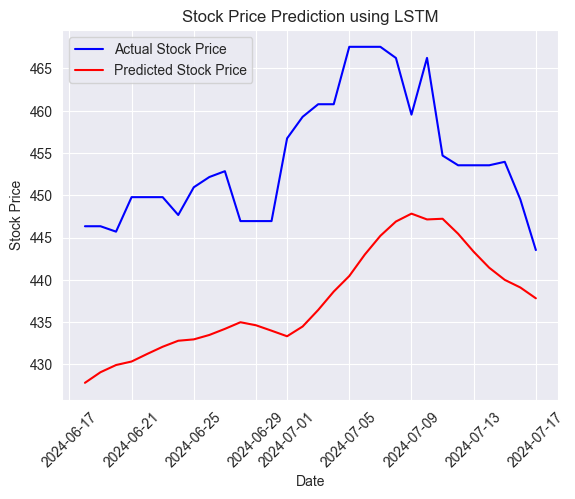

In [1190]:
# To see closer the results
d = 30
plt.plot(df.index[train_size+sequence_length:][-30:], df['Close'].values[train_size+sequence_length:][-30:], color='blue', label='Actual Stock Price')
plt.plot(df.index[train_size+sequence_length:][-30:], predicted_test[-30:], color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()